In [1]:
!gdown --id 1SEprCaRetePqy5pNsFKA9rXwB1d3TGmx
!unzip -q capstone.zip

Downloading...
From: https://drive.google.com/uc?id=1SEprCaRetePqy5pNsFKA9rXwB1d3TGmx
To: /content/capstone.zip
2.55MB [00:00, 40.1MB/s]


In [2]:
import os
import re
import itertools
import warnings
from joblib import dump

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats, signal
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

warnings.filterwarnings("ignore")
random_state = 42
activities = ["hair", "listen", "sidepump", "dab", "wipe", "gun", "elbow", "pointhigh"]
n_labels = len(activities)

In [3]:
dfs = []

def load_data(activity, label, trails, subject):
    for trail in trails:
        df = pd.read_csv(os.path.join(subject, activity+str(trail)+".txt"), sep=" ", header=None)
        df = df[60:-60]
        df.columns = ["yaw", "pitch", "roll", "acc_x", "acc_y", "acc_z"]
        df["activity"] = [label for _ in range(len(df))]
        df["activityName"] = [activity for _ in range(len(df))]
        dfs.append(df)

load_data("hair", 0, [1, 2, 3, 4, 5], "riyas")
load_data("listen", 1, [1, 2, 3, 4, 5], "riyas")
load_data("sidepump", 2, [1, 2, 3, 4, 5], "riyas")
load_data("dab", 3, [1, 2, 3, 4, 5], "riyas")
load_data("wipe", 4, [1, 2, 3, 4, 5], "riyas")
load_data("gun", 5, [1, 2, 3, 4, 5], "riyas")
load_data("elbow", 6, [1, 2, 3, 4, 5, 6, 7, 8], "riyas")
load_data("pointhigh", 7, [1, 2, 3, 4, 5], "riyas")

df = pd.concat(dfs)
df.shape

(108010, 8)

In [4]:
def convert_to_timeseries(features, num_time_steps, num_features):
    data = np.reshape(features, newshape=(num_time_steps, num_features))
    return data.T

num_time_steps = 60
X = list()
y = list()
df_len = len(df)
for idx in range(0, df_len, num_time_steps//2):
    window_df = df[idx:idx+num_time_steps]
    labels = window_df["activity"].unique()
    if len(labels) != 1 or len(window_df) < num_time_steps:
        continue
    assert len(labels) == 1 and len(window_df) == num_time_steps
    features = window_df.drop(columns=["activity", "activityName"]).values
    features = convert_to_timeseries(features, num_time_steps=num_time_steps, num_features=6)
    X.append(features)
    y.append(labels)

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((3585, 6, 60), (3585, 1))

In [5]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmap='Reds'
        print("Normalized Confusion Matrix")
    else:
        cmap='Greens'
        print('Confusion Matrix Without Normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            上次验证集损失值改善后等待几个epoch
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            如果是True，为每个验证集损失值改善打印一条信息
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            监测数量的最小变化，以符合改进的要求
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        验证损失减少时保存模型。
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, 'finish_model.pkl')                 # 这里会存储迄今最优的模型
        self.val_loss_min = val_loss

def plot_avg_loss_per_epoch(avg_train_losses, avg_valid_losses):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(avg_train_losses)+1), avg_train_losses, label='Training Loss')
    plt.plot(range(1,len(avg_valid_losses)+1), avg_valid_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = avg_train_losses.index(min(avg_train_losses))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 2) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_accuracy_per_epoch(train_accuracies, valid_accuracies):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1,len(valid_accuracies)+1), valid_accuracies,label='Valid Accuracy')

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim(0, 1) # consistent scale
    plt.xlim(0, len(train_accuracies)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
class MLTrainer:
    def __init__(self, model, X_train, X_valid, y_train, y_valid, n_splits=5, random_state=42, shuffle=True):
        self.model = model
        self.X_train = X_train
        self.X_valid = X_valid
        self.y_train = y_train
        self.y_valid = y_valid

        self.n_splits = n_splits
        self.random_state = random_state
        self.shuffle = shuffle
        
        self.clf = None
        self.valid_accuracy = None

    def train(self):
        kf = KFold(n_splits=self.n_splits, random_state=self.random_state, shuffle=self.shuffle)
        X, y = pd.concat([self.X_train, self.X_valid]), pd.concat([self.y_train, self.y_valid])

        accs = []
        for train_index, valid_index in kf.split(X):
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_valid, y_valid =  X.iloc[valid_index], y.iloc[valid_index]
        
            clf = self.train_split(X_train, y_train)
            accs.append(self.validate_split(clf, X_valid, y_valid))

        self.valid_accuracy = np.mean(accs)

        self.clf = self.model.fit(X, y.values.ravel())

    def train_split(self, X_train, y_train):
        return self.model.fit(X_train, y_train.values.ravel())

    def validate_split(self, clf, X_valid, y_valid):
        pred = clf.predict(X_valid)
        return accuracy_score(pred, y_valid)

    def evaluate(self, X_test, y_test):
        pred = self.clf.predict(X_test)
        return accuracy_score(pred, y_test), (y_test, pred)

    def show_evaluation(self):
        return self.model.__class__.__name__, self.valid_accuracy

In [8]:
class DLTrainer:
    def __init__(self, model, trainloader, validloader, testloader, criterion, optimizer, early_stopping, n_epochs, patience, is_time_series=False):
        self.model = model
        self.trainloader = trainloader
        self.validloader = validloader
        self.testloader = testloader
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.early_stopping = early_stopping
        self.n_epochs = n_epochs
        self.patience = patience
        self.is_time_series = is_time_series

        self.avg_train_losses = []
        self.avg_valid_losses = [] 
        self.train_accuracies = []
        self.valid_accuracies = []

    def train(self):
        self.model.cuda()
        for epoch in range(self.n_epochs):  # loop over the dataset multiple times
            train_correct, train_total, train_loss = self.train_epoch()
            valid_correct, valid_total, valid_loss = self.validate_epoch()

            # calculate average loss over an epoch
            train_accuracy = train_correct / train_total
            valid_accuracy = valid_correct / valid_total

            self.avg_train_losses.append(train_loss)
            self.avg_valid_losses.append(valid_loss)
            self.train_accuracies.append(train_accuracy)
            self.valid_accuracies.append(valid_accuracy)

            log_message = f'[{str(epoch)}/{str(self.n_epochs)}] train_loss: {train_loss:.5f} valid_loss: {valid_loss:.5f} train_accuracy: {train_accuracy:.5f} valid_accuracy: {valid_accuracy:.5f}'
            print(log_message)

            self.early_stopping(valid_loss, self.model)
            
            if self.early_stopping.early_stop:
                break

    def train_epoch(self):
        correct = 0
        total = 0
        losses = []

        self.model.train()
        for data in self.trainloader:
            inputs, labels = data
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")

            self.optimizer.zero_grad()

            outputs = self.model(inputs.float())

            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        return correct, total, np.mean(losses)

    def validate_epoch(self):
        correct = 0
        total = 0
        losses = []

        self.model.eval()
        for data in validloader:
            inputs, labels = data
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")

            outputs = self.model(inputs.float())
            loss = self.criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        return correct, total, np.mean(losses)

    def evaluate(self, dataloader):
        correct = 0
        total = 0
        actual = []
        expected = []

        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data
                inputs = inputs.to("cuda")
                labels = labels.to("cuda")
                outputs = self.model(inputs.float())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                expected += labels.cpu()
                actual += predicted.cpu()

        return correct/total, (expected, actual)

    def show_evaluation(self):
        return self.avg_train_losses, self.avg_valid_losses, self.train_accuracies, self.valid_accuracies


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)
X_train.shape

(2868, 6, 60)

In [10]:
scaler = preprocessing.StandardScaler()
# https://stackoverflow.com/questions/53870113/using-standardscaler-on-3d-data
def scale_data(data, is_train=False):
    num_instances, num_time_steps, num_features = data.shape
    data = np.reshape(data, newshape=(-1, num_features))
    if is_train:
        data = scaler.fit_transform(data)
    else:
        data = scaler.transform(data)
    data = np.reshape(data, newshape=(num_instances, num_time_steps, num_features))
    return data

X_train = scale_data(X_train, is_train=True)
X_valid = scale_data(X_valid)
X_test = scale_data(X_test)
X_train.shape

(2868, 6, 60)

In [11]:
class CNNDataset(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        data = self.X[idx]
        target = self.y[idx][0]
        return data, target

    def __len__(self):
        return len(self.X)

def prepare_cnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test):
    traindataset = CNNDataset(X_train, y_train)

    trainloader = torch.utils.data.DataLoader(
        traindataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    validdataset = CNNDataset(X_valid, y_valid)

    validloader = torch.utils.data.DataLoader(
        validdataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    testdataset = CNNDataset(X_test, y_test)

    testloader = torch.utils.data.DataLoader(
        testdataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    return trainloader, validloader, testloader

In [12]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(6, 32, 3)
        self.relu1 = nn.ReLU()
        self.dp1 = nn.Dropout(0.6)

        self.pool1 = nn.MaxPool1d(2)
        self.flat1 = nn.Flatten()
        self.dp2 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(928, 256)
        self.relu2 = nn.ReLU()
        self.dp3 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(256, 128)
        self.dp4 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(128, 9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dp1(x)

        x = self.pool1(x)
        x = self.flat1(x)
        x = self.dp2(x)

        x = self.fc1(x)
        x = self.relu2(x)
        x = self.dp3(x)

        x = self.fc2(x)
        x = self.dp4(x)

        x = self.fc3(x)
        
        return x

trainloader, validloader, testloader = prepare_cnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test)
inputs, labels = next(iter(trainloader))
model = CNN()
outputs = model(inputs.float())
labels[:1], outputs[:1]

(tensor([6]),
 tensor([[ 0.0652, -0.1343,  0.1186,  0.1354,  0.1198, -0.0394,  0.0854, -0.1142,
           0.0401]], grad_fn=<SliceBackward>))

In [13]:
patience = 10
n_epochs = 1000

model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
early_stopping = EarlyStopping(patience=patience)
trainloader, validloader, testloader = prepare_cnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test)

trainer = DLTrainer(model, trainloader, validloader, testloader, criterion, optimizer, early_stopping, n_epochs, patience, is_time_series=True)
trainer.train()

[0/1000] train_loss: 2.18682 valid_loss: 2.15833 train_accuracy: 0.14296 valid_accuracy: 0.23743
[1/1000] train_loss: 2.11845 valid_loss: 2.10734 train_accuracy: 0.21757 valid_accuracy: 0.22905
[2/1000] train_loss: 2.05103 valid_loss: 2.05306 train_accuracy: 0.25174 valid_accuracy: 0.21788
[3/1000] train_loss: 1.97702 valid_loss: 1.99489 train_accuracy: 0.27057 valid_accuracy: 0.30168
[4/1000] train_loss: 1.89555 valid_loss: 1.90561 train_accuracy: 0.31102 valid_accuracy: 0.44693
[5/1000] train_loss: 1.79318 valid_loss: 1.80219 train_accuracy: 0.38982 valid_accuracy: 0.57542
[6/1000] train_loss: 1.66890 valid_loss: 1.68063 train_accuracy: 0.44840 valid_accuracy: 0.71508
[7/1000] train_loss: 1.51658 valid_loss: 1.52607 train_accuracy: 0.51255 valid_accuracy: 0.77095
[8/1000] train_loss: 1.35473 valid_loss: 1.35766 train_accuracy: 0.57880 valid_accuracy: 0.79330
[9/1000] train_loss: 1.20017 valid_loss: 1.21933 train_accuracy: 0.63494 valid_accuracy: 0.80726
[10/1000] train_loss: 1.09663 

In [14]:
cnn_valid_accuracy, cnn_valid_prediction = trainer.evaluate(validloader)
cnn_test_accuracy, cnn_test_prediction = trainer.evaluate(testloader)
cnn_valid_accuracy, cnn_test_accuracy

(0.9748603351955307, 0.9749303621169917)

Confusion Matrix Without Normalization


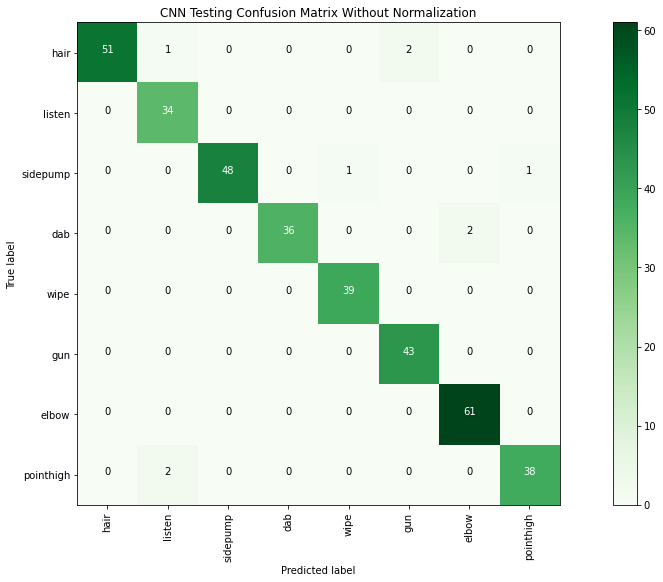

Normalized Confusion Matrix


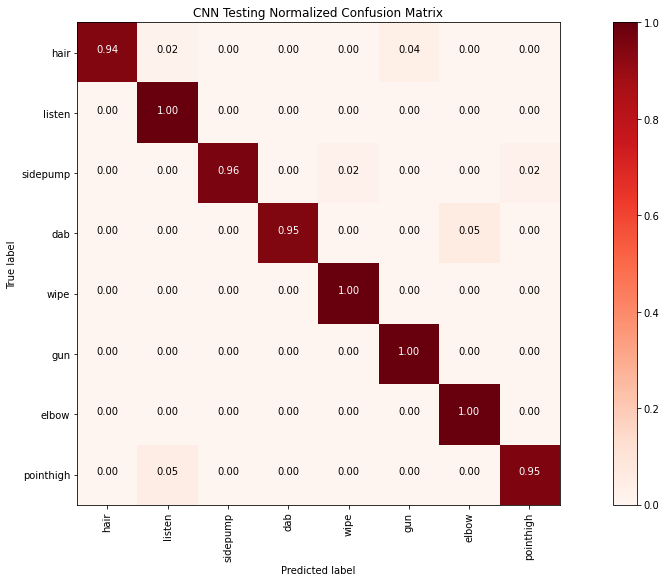

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(*cnn_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='CNN Testing Normalized Confusion Matrix')

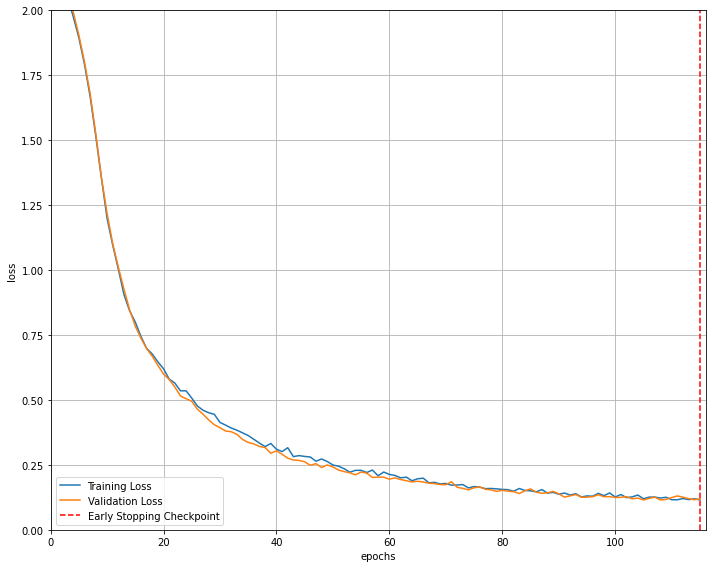

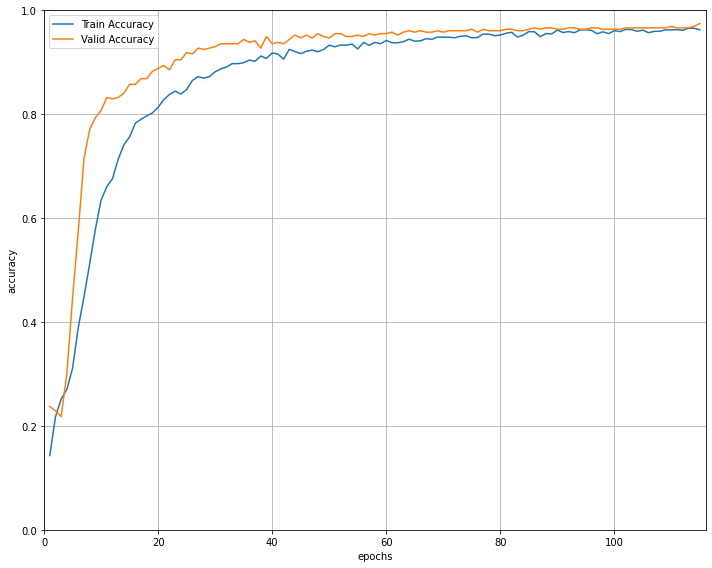

In [16]:
avg_train_losses, avg_valid_losses, train_accuracies, valid_accuracies = trainer.show_evaluation()
plot_avg_loss_per_epoch(avg_train_losses, avg_valid_losses)
plot_accuracy_per_epoch(train_accuracies, valid_accuracies)

In [17]:
def compute_mean(data):
    return np.mean(data)

def compute_variance(data):
    return np.var(data)

def compute_median_absolute_deviation(data):
    return stats.median_absolute_deviation(data)

def compute_root_mean_square(data):
    def compose(*fs):
        def wrapped(x):
            for f in fs[::-1]:
                x = f(x)
            return x
        return wrapped
    rms = compose(np.sqrt, np.mean, np.square)
    return rms(data)

def compute_interquartile_range(data):
    return stats.iqr(data)

def compute_percentile_75(data):
    return np.percentile(data, 75)

def compute_kurtosis(data):
    return stats.kurtosis(data)

def compute_min_max(data):
    return np.max(data) - np.min(data)

def compute_signal_magnitude_area(data):
    return np.sum(data) / len(data)

def compute_zero_crossing_rate(data):
    return ((data[:-1] * data[1:]) < 0).sum()

def compute_spectral_centroid(data):
    spectrum = np.abs(np.fft.rfft(data))
    normalized_spectrum = spectrum / np.sum(spectrum)  # like a probability mass function
    normalized_frequencies = np.linspace(0, 1, len(spectrum))
    spectral_centroid = np.sum(normalized_frequencies * normalized_spectrum)
    return spectral_centroid

def compute_spectral_entropy(data):
    freqs, power_density = signal.welch(data)
    return stats.entropy(power_density)

def compute_spectral_energy(data):
    freqs, power_density = signal.welch(data)
    return np.sum(np.square(power_density))

def compute_principle_frequency(data):
    freqs, power_density = signal.welch(data)
    return freqs[np.argmax(np.square(power_density))]

In [18]:
feature_names = []
for i in ["yaw", "pitch", "row", "acc_x", "acc_y", "acc_z"]:
        for j in ["_mean", "_var", "_mad", "_rms", "_iqr", "_per75", "_kurtosis", "_min_max", "_sma", "_zcr", "_sc", "_entropy", "_energy", "_pfreq"]:
            feature_names.append(i+j)

n_features = len(feature_names)

def rename_raw_data_headers(X, columns):
    X = pd.DataFrame(X)
    X.columns = columns
    return X

def extract_raw_data_features_per_row(f_n):
    f1_mean = compute_mean(f_n)
    f1_var = compute_variance(f_n)
    f1_mad = compute_median_absolute_deviation(f_n)
    f1_rms = compute_root_mean_square(f_n)
    f1_iqr = compute_interquartile_range(f_n)
    f1_per75 = compute_percentile_75(f_n)
    f1_kurtosis = compute_kurtosis(f_n)
    f1_min_max = compute_min_max(f_n)
    f1_sma = compute_signal_magnitude_area(f_n)
    f1_zcr = compute_zero_crossing_rate(f_n)
    f1_sc = compute_spectral_centroid(f_n)
    f1_entropy = compute_spectral_entropy(f_n)
    f1_energy = compute_spectral_energy(f_n)
    f1_pfreq = compute_principle_frequency(f_n)
    return f1_mean, f1_var, f1_mad, f1_rms, f1_iqr, f1_per75, f1_kurtosis, f1_min_max, f1_sma, f1_zcr, f1_sc, f1_entropy, f1_energy, f1_pfreq

def extract_raw_data_features(X):
    new_features = np.ones((X.shape[0], n_features))
    rows = X.shape[0]
    cols = X.shape[1]

    for row in range(rows):
        features = []
        for col in range(cols):
            f_n = X[row][col]
            feature = extract_raw_data_features_per_row(f_n)
            features.extend(feature)
        new_features[row] = np.array(features)

    return new_features


def prepare_raw_data_dataframe(X, y, random_state=42):
    X = extract_raw_data_features(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_raw_data_dataframe(X, y)

In [19]:
scaler = preprocessing.StandardScaler()

def scale_data(data, is_train=False):
    if is_train:
        data = scaler.fit_transform(data)
    else:
        data = scaler.transform(data)
    return data

X_train = scale_data(X_train, is_train=True)
X_valid = scale_data(X_valid)
X_test = scale_data(X_test)
X_train.shape

(2151, 84)

In [20]:
def rename_raw_data_headers(X, columns):
    X = pd.DataFrame(X)
    X.columns = columns
    return X

X_explore = np.concatenate((X_train, X_valid, X_test), axis=0)
X_explore = rename_raw_data_headers(X_explore, feature_names)
y_explore = np.concatenate((y_train, y_valid, y_test), axis=0)
X_explore["activity"] = y_explore[:, 0]
X_explore["activityName"] = X_explore["activity"].replace([0,1,2,3,4,5,6,7], activities)
X_explore.sample()

,yaw_mean,yaw_var,yaw_mad,yaw_rms,yaw_iqr,yaw_per75,yaw_kurtosis,yaw_min_max,yaw_sma,yaw_zcr,yaw_sc,yaw_entropy,yaw_energy,yaw_pfreq,pitch_mean,pitch_var,pitch_mad,pitch_rms,pitch_iqr,pitch_per75,pitch_kurtosis,pitch_min_max,pitch_sma,pitch_zcr,pitch_sc,pitch_entropy,pitch_energy,pitch_pfreq,row_mean,row_var,row_mad,row_rms,row_iqr,row_per75,row_kurtosis,row_min_max,row_sma,row_zcr,row_sc,row_entropy,...,acc_x_iqr,acc_x_per75,acc_x_kurtosis,acc_x_min_max,acc_x_sma,acc_x_zcr,acc_x_sc,acc_x_entropy,acc_x_energy,acc_x_pfreq,acc_y_mean,acc_y_var,acc_y_mad,acc_y_rms,acc_y_iqr,acc_y_per75,acc_y_kurtosis,acc_y_min_max,acc_y_sma,acc_y_zcr,acc_y_sc,acc_y_entropy,acc_y_energy,acc_y_pfreq,acc_z_mean,acc_z_var,acc_z_mad,acc_z_rms,acc_z_iqr,acc_z_per75,acc_z_kurtosis,acc_z_min_max,acc_z_sma,acc_z_zcr,acc_z_sc,acc_z_entropy,acc_z_energy,acc_z_pfreq,activity,activityName
3503,-0.155618,-0.307948,0.629749,-0.344967,0.232037,0.021541,-0.397983,-0.145921,-0.155618,-0.141251,-0.855372,-0.666655,-0.307022,-0.472785,0.458397,-0.323268,0.032157,-0.939695,-0.151262,0.202832,-0.336952,-0.245961,0.458397,0.991041,-0.565021,-0.576541,-0.181514,-0.421787,-0.170115,-0.67666,-0.594319,-0.312029,-0.662137,-0.467512,-0.146019,-0.731252,-0.170115,-0.852973,-0.755858,0.264591,...,0.121862,0.741019,-0.312964,-0.080585,0.649379,0.015568,-0.045331,-0.665067,-0.039265,-0.605786,0.064902,0.58425,0.902389,0.128268,0.575407,-0.069911,-0.117844,0.379934,0.064902,-0.603032,-0.839197,-0.929564,0.07435,-0.822154,-1.174212,-0.927329,-0.748905,-1.348792,-0.956769,-1.338817,0.076214,-1.108424,-1.174212,-0.59928,-0.244735,-0.263637,-0.462351,-0.734178,6,elbow


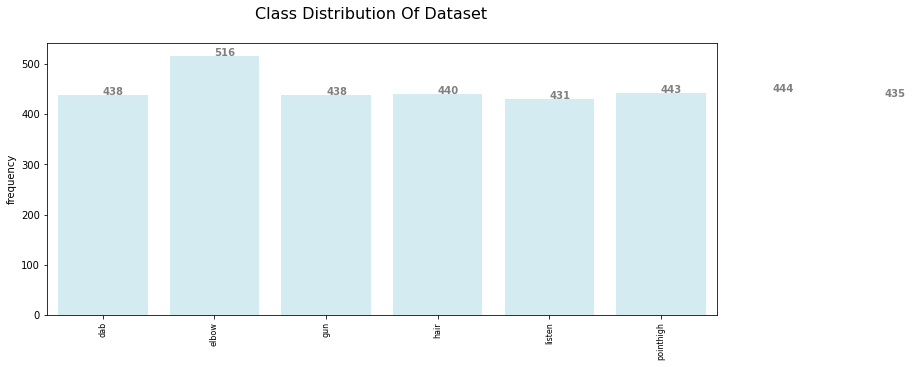

In [33]:
def plot_distribution_of_data(df, title=""):
    activity, counts = np.unique(df.activityName, return_counts=True)
    index = np.arange(len(activity))
    plt.figure(figsize=(12, 5))
    plt.bar(index, counts, align = 'center', alpha=0.5, color='lightblue')
    plt.suptitle(title, fontsize=16)
    plt.xticks(index, activity, rotation=90, fontsize=8)
    plt.xlim([-.5, 5.5])
    plt.ylabel('frequency', fontsize=10)
    for i, v in enumerate(counts):
        plt.text(i, v, str(v), color='grey', fontweight='bold')
    plt.show()

plot_distribution_of_data(X_explore, title='Class Distribution Of Dataset')

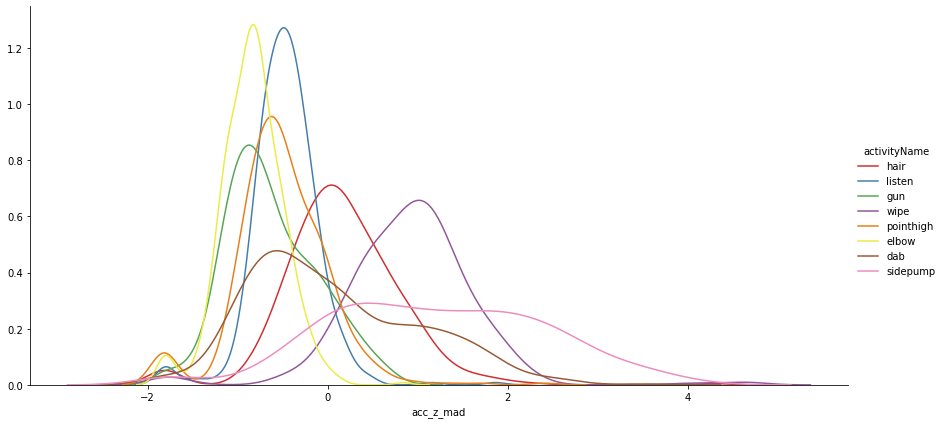

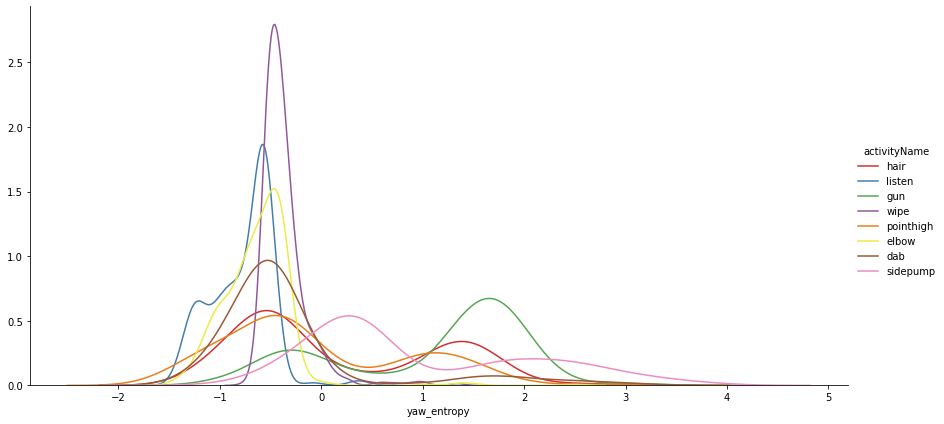

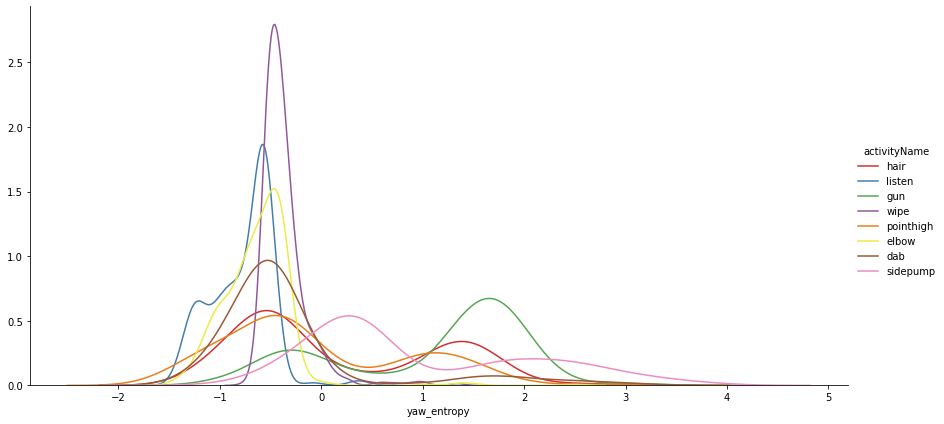

In [21]:
exploratory_features = ["acc_z_mad", "yaw_entropy", "yaw_entropy"]

def plot_histogram_activity_distribution(df, feature):
    sns.set_palette("Set1", desat=0.80)
    facetgrid = sns.FacetGrid(df, hue='activityName', size=6,aspect=2)
    facetgrid.map(sns.distplot, feature, hist=False).add_legend()
    plt.show()

for feature in exploratory_features:
    plot_histogram_activity_distribution(X_explore, feature)

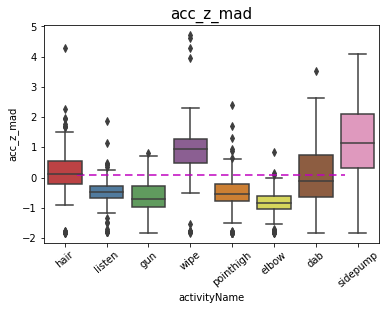

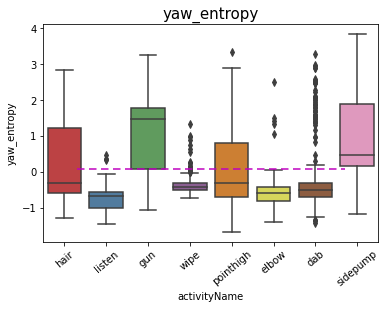

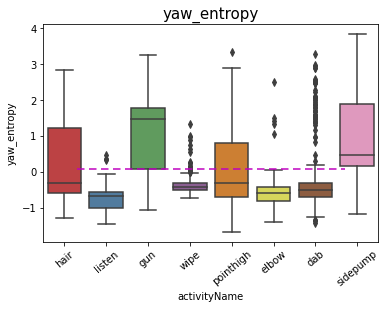

In [22]:
exploratory_features = ["acc_z_mad", "yaw_entropy", "yaw_entropy"]

def plot_boxplot_activity_distribution(data, y):
    sns.boxplot(x='activityName', y=y, data=data)
    plt.axhline(y=0.08, xmin=0.1, xmax=0.9,c='m',dashes=(5,3))
    plt.title(feature, fontsize=15)
    plt.xticks(rotation = 40)
    plt.show()

for feature in exploratory_features:
    plot_boxplot_activity_distribution(X_explore, feature)

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 3585 samples in 0.025s...
[t-SNE] Computed neighbors for 3585 samples in 1.400s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3585
[t-SNE] Computed conditional probabilities for sample 2000 / 3585
[t-SNE] Computed conditional probabilities for sample 3000 / 3585
[t-SNE] Computed conditional probabilities for sample 3585 / 3585
[t-SNE] Mean sigma: 0.640362
[t-SNE] Computed conditional probabilities in 0.021s
[t-SNE] Iteration 50: error = 115.7465057, gradient norm = 0.0909923 (50 iterations in 1.501s)
[t-SNE] Iteration 100: error = 96.8825989, gradient norm = 0.0864589 (50 iterations in 0.936s)
[t-SNE] Iteration 150: error = 90.4348526, gradient norm = 0.0639400 (50 iterations in 0.769s)
[t-SNE] Iteration 200: error = 86.7402878, gradient norm = 0.0539282 (50 iterations in 0.761s)
[t-SNE] Iteration 250: error = 84.1959229, gradient norm = 0.0519969 (50 iterations in 0.754s)
[t-SNE] KL divergence after 250 iterati

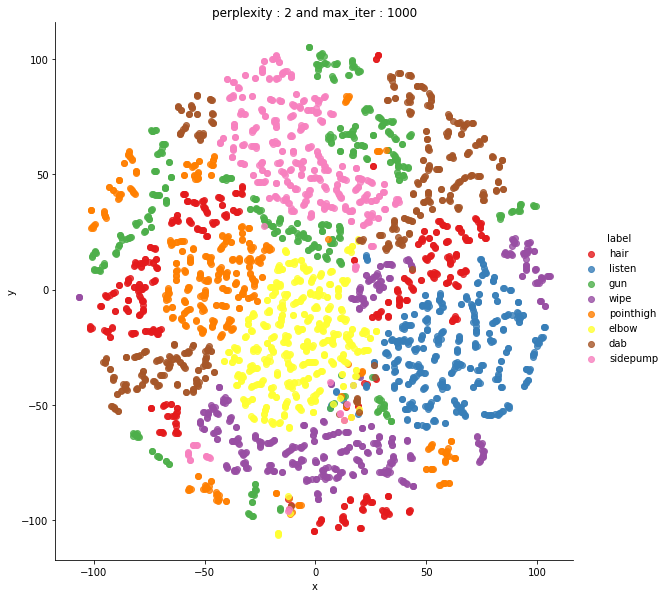

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 3585 samples in 0.030s...
[t-SNE] Computed neighbors for 3585 samples in 1.653s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3585
[t-SNE] Computed conditional probabilities for sample 2000 / 3585
[t-SNE] Computed conditional probabilities for sample 3000 / 3585
[t-SNE] Computed conditional probabilities for sample 3585 / 3585
[t-SNE] Mean sigma: 1.058496
[t-SNE] Computed conditional probabilities in 0.030s
[t-SNE] Iteration 50: error = 103.6313248, gradient norm = 0.0958353 (50 iterations in 1.373s)
[t-SNE] Iteration 100: error = 85.9251099, gradient norm = 0.0452496 (50 iterations in 0.890s)
[t-SNE] Iteration 150: error = 80.9341431, gradient norm = 0.0327042 (50 iterations in 0.797s)
[t-SNE] Iteration 200: error = 78.2508621, gradient norm = 0.0250951 (50 iterations in 0.760s)
[t-SNE] Iteration 250: error = 76.5139618, gradient norm = 0.0303750 (50 iterations in 0.740s)
[t-SNE] KL divergence after 250 iterat

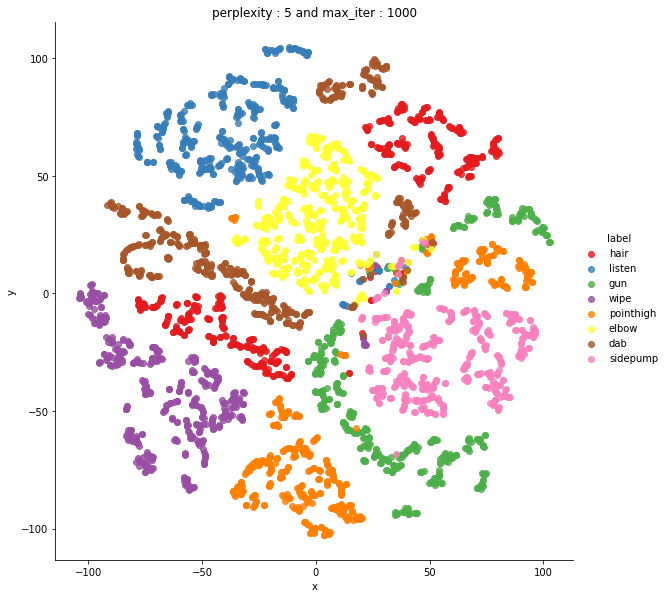

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3585 samples in 0.032s...
[t-SNE] Computed neighbors for 3585 samples in 1.789s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3585
[t-SNE] Computed conditional probabilities for sample 2000 / 3585
[t-SNE] Computed conditional probabilities for sample 3000 / 3585
[t-SNE] Computed conditional probabilities for sample 3585 / 3585
[t-SNE] Mean sigma: 1.327349
[t-SNE] Computed conditional probabilities in 0.055s
[t-SNE] Iteration 50: error = 92.5187225, gradient norm = 0.0826687 (50 iterations in 1.561s)
[t-SNE] Iteration 100: error = 76.9549561, gradient norm = 0.0304350 (50 iterations in 0.838s)
[t-SNE] Iteration 150: error = 73.1805267, gradient norm = 0.0200450 (50 iterations in 0.753s)
[t-SNE] Iteration 200: error = 71.2752380, gradient norm = 0.0181729 (50 iterations in 0.755s)
[t-SNE] Iteration 250: error = 70.0329285, gradient norm = 0.0151075 (50 iterations in 0.764s)
[t-SNE] KL divergence after 250 iterati

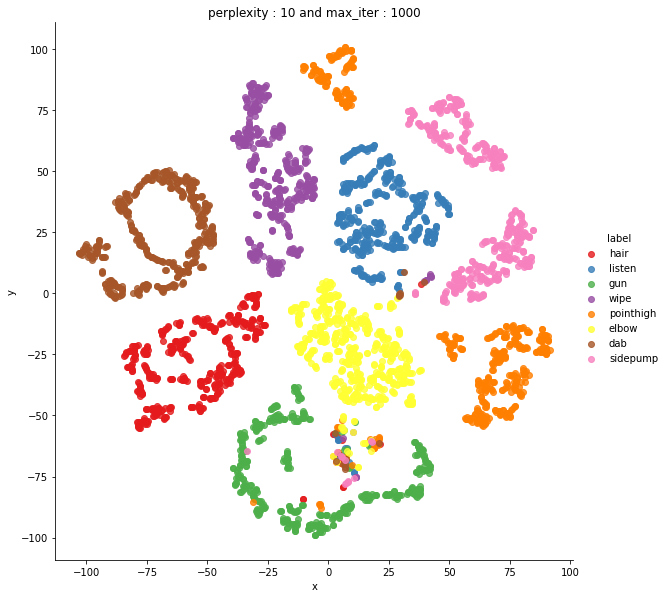

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3585 samples in 0.052s...
[t-SNE] Computed neighbors for 3585 samples in 1.887s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3585
[t-SNE] Computed conditional probabilities for sample 2000 / 3585
[t-SNE] Computed conditional probabilities for sample 3000 / 3585
[t-SNE] Computed conditional probabilities for sample 3585 / 3585
[t-SNE] Mean sigma: 1.595869
[t-SNE] Computed conditional probabilities in 0.109s
[t-SNE] Iteration 50: error = 82.2109375, gradient norm = 0.0714452 (50 iterations in 1.520s)
[t-SNE] Iteration 100: error = 69.4201508, gradient norm = 0.0195869 (50 iterations in 0.991s)
[t-SNE] Iteration 150: error = 66.4186859, gradient norm = 0.0136612 (50 iterations in 0.884s)
[t-SNE] Iteration 200: error = 65.0417557, gradient norm = 0.0113580 (50 iterations in 0.858s)
[t-SNE] Iteration 250: error = 64.2266693, gradient norm = 0.0085844 (50 iterations in 0.821s)
[t-SNE] KL divergence after 250 iterati

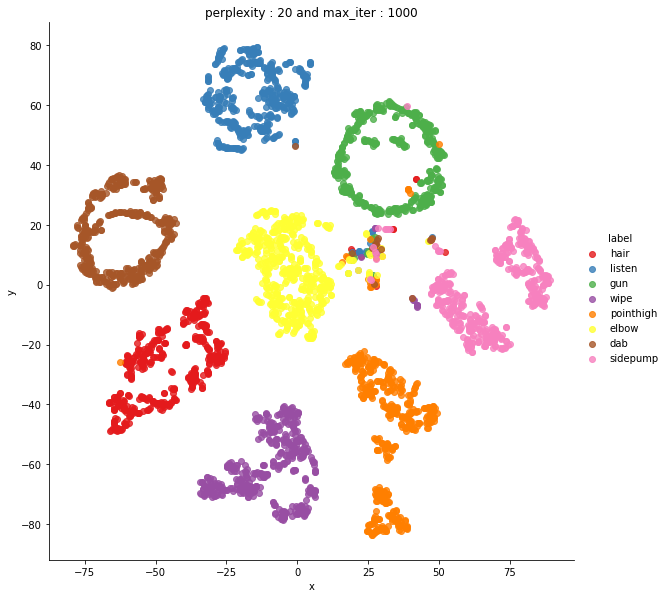

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3585 samples in 0.033s...
[t-SNE] Computed neighbors for 3585 samples in 2.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3585
[t-SNE] Computed conditional probabilities for sample 2000 / 3585
[t-SNE] Computed conditional probabilities for sample 3000 / 3585
[t-SNE] Computed conditional probabilities for sample 3585 / 3585
[t-SNE] Mean sigma: 2.024895
[t-SNE] Computed conditional probabilities in 0.279s
[t-SNE] Iteration 50: error = 72.2924576, gradient norm = 0.0485476 (50 iterations in 1.797s)
[t-SNE] Iteration 100: error = 61.0501213, gradient norm = 0.0188062 (50 iterations in 1.344s)
[t-SNE] Iteration 150: error = 58.9383850, gradient norm = 0.0080056 (50 iterations in 1.230s)
[t-SNE] Iteration 200: error = 58.1046829, gradient norm = 0.0078091 (50 iterations in 1.218s)
[t-SNE] Iteration 250: error = 57.6625137, gradient norm = 0.0055395 (50 iterations in 1.148s)
[t-SNE] KL divergence after 250 iterat

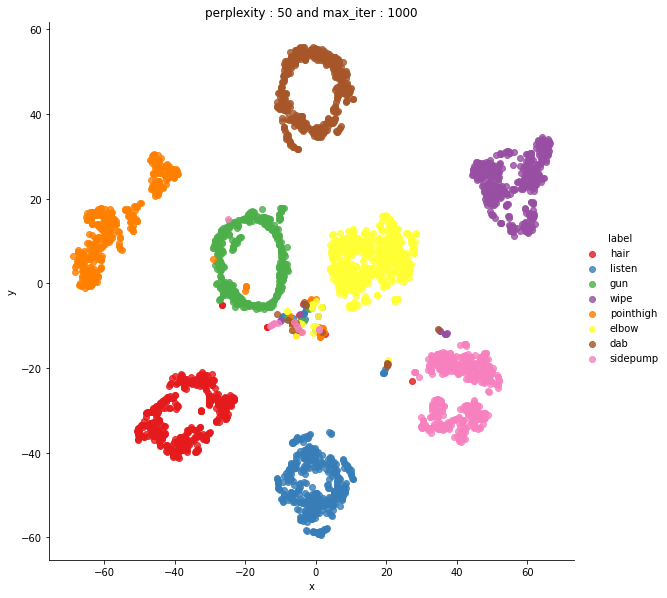

In [23]:
perplexities = [2,5,10,20,50]

def plot_tsne(X_data, y_data, perplexity, n_iter=1000, img_name_prefix='t-sne'):
    # perform t-sne
    X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)
    
    # prepare the data for seaborn         
    df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1] ,'label':y_data})
    
    # draw the plot in appropriate place in the grid
    sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,\
                palette="Set1")
    plt.title("perplexity : {} and max_iter : {}".format(perplexity, n_iter))
    img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
    plt.show()

for perplexity in perplexities:
    X_pre_tsne = X_explore.drop(columns=['activityName'], axis=1)
    y_pre_tsne = X_explore['activityName']
    plot_tsne(X_data=X_pre_tsne, y_data=y_pre_tsne, perplexity=perplexity)

In [24]:
trainer = MLTrainer(SVC(kernel='rbf', C=1000, gamma = 0.001, class_weight='balanced', probability=True), X_train=pd.DataFrame(X_train), X_valid=pd.DataFrame(X_valid), y_train=pd.DataFrame(y_train), y_valid=pd.DataFrame(y_valid))

trainer.train()
svc_model_name, svc_valid_accuracy = trainer.show_evaluation()
svc_test_accuracy, svc_test_prediction = trainer.evaluate(X_test=pd.DataFrame(X_test), y_test=pd.DataFrame(y_test))

print(svc_valid_accuracy, svc_test_accuracy)

0.9839599637582015 0.9790794979079498


Confusion Matrix Without Normalization


<Figure size 1080x576 with 0 Axes>

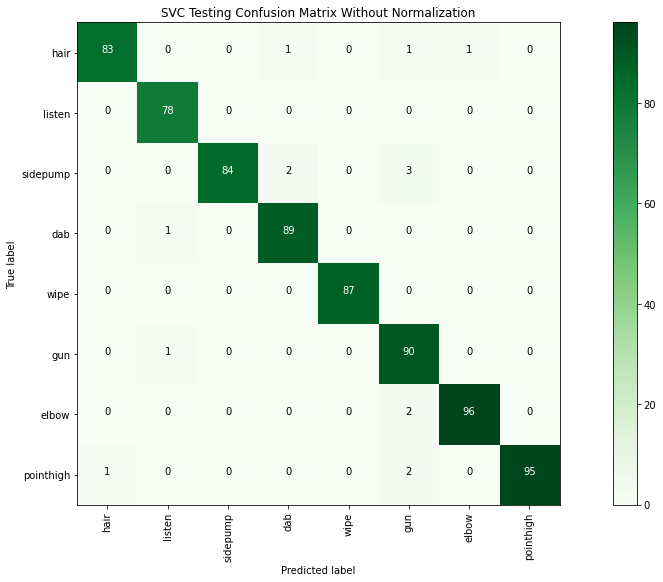

Normalized Confusion Matrix


<Figure size 1080x576 with 0 Axes>

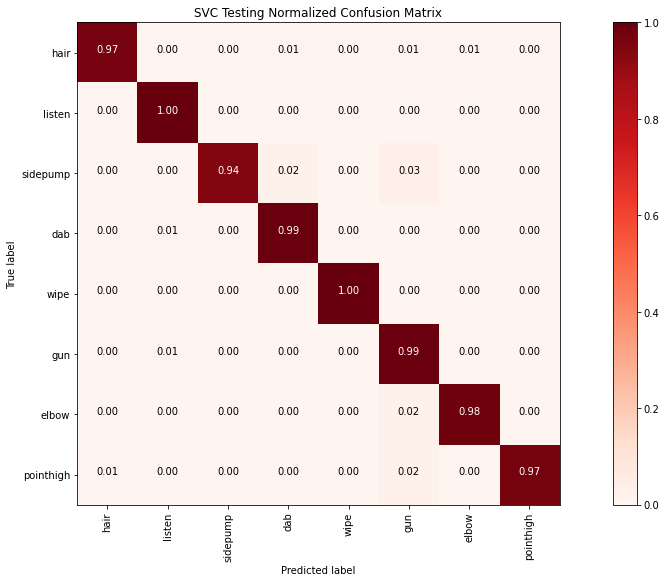

In [25]:
cnf_matrix = confusion_matrix(*svc_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=activities, title='SVC Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='SVC Testing Normalized Confusion Matrix')

plt.show()

In [26]:
class DNNDataset(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        data = self.X[idx]
        target = self.y[idx][0] 
        return data, target

    def __len__(self):
        return len(self.X)

def prepare_dnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test):
    traindataset = DNNDataset(X_train, y_train)

    trainloader = torch.utils.data.DataLoader(
        traindataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    validdataset = DNNDataset(X_valid, y_valid)

    validloader = torch.utils.data.DataLoader(
        validdataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    testdataset = DNNDataset(X_test, y_test)

    testloader = torch.utils.data.DataLoader(
        testdataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    return trainloader, validloader, testloader

In [27]:
class DNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(84, 70)
        self.dp1 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(70, 50)
        self.dp2 = nn.Dropout(0.1)

        self.fc3 = nn.Linear(50, 20)
        self.dp3 = nn.Dropout(0.1)
        
        self.fc4 = nn.Linear(20,9)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)

        x = self.fc2(x)
        x = self.dp2(x)

        x = self.fc3(x)
        x = self.dp3(x)

        x = self.fc4(x)
        return x

trainloader, validloader, testloader = prepare_dnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test)
inputs, labels = next(iter(trainloader))
model = DNN()
outputs = model(inputs.float())
labels[:1], outputs[:1]

(tensor([4]),
 tensor([[-0.2865,  0.1808,  0.0771,  0.0290,  0.0289, -0.1719,  0.1484, -0.0138,
          -0.4133]], grad_fn=<SliceBackward>))

In [28]:
patience = 10
n_epochs = 1000

model = DNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
early_stopping = EarlyStopping(patience=patience)
trainloader, validloader, testloader = prepare_dnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test)

trainer = DLTrainer(model, trainloader, validloader, testloader, criterion, optimizer, early_stopping, n_epochs, patience)
trainer.train()

[0/1000] train_loss: 2.19882 valid_loss: 2.14729 train_accuracy: 0.06044 valid_accuracy: 0.08229
[1/1000] train_loss: 2.10177 valid_loss: 2.03780 train_accuracy: 0.18178 valid_accuracy: 0.36123
[2/1000] train_loss: 1.98281 valid_loss: 1.91577 train_accuracy: 0.39702 valid_accuracy: 0.58438
[3/1000] train_loss: 1.84887 valid_loss: 1.75665 train_accuracy: 0.60251 valid_accuracy: 0.79358
[4/1000] train_loss: 1.69563 valid_loss: 1.57470 train_accuracy: 0.72152 valid_accuracy: 0.81590
[5/1000] train_loss: 1.52349 valid_loss: 1.42982 train_accuracy: 0.76430 valid_accuracy: 0.79637
[6/1000] train_loss: 1.35624 valid_loss: 1.24465 train_accuracy: 0.77034 valid_accuracy: 0.78801
[7/1000] train_loss: 1.19463 valid_loss: 1.13520 train_accuracy: 0.77080 valid_accuracy: 0.78661
[8/1000] train_loss: 1.06188 valid_loss: 0.98469 train_accuracy: 0.77731 valid_accuracy: 0.79219
[9/1000] train_loss: 0.95409 valid_loss: 0.88149 train_accuracy: 0.78940 valid_accuracy: 0.80893
[10/1000] train_loss: 0.85232 

In [29]:
dnn_valid_accuracy, dnn_valid_prediction = trainer.evaluate(validloader)
dnn_test_accuracy, dnn_test_prediction = trainer.evaluate(testloader)
print(dnn_valid_accuracy, dnn_test_accuracy)

0.9762900976290098 0.9735006973500697


Confusion Matrix Without Normalization


<Figure size 1080x576 with 0 Axes>

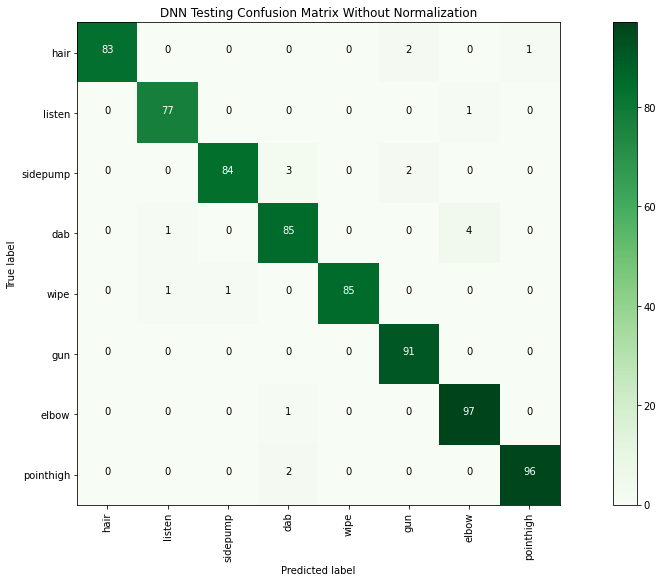

Normalized Confusion Matrix


<Figure size 1080x576 with 0 Axes>

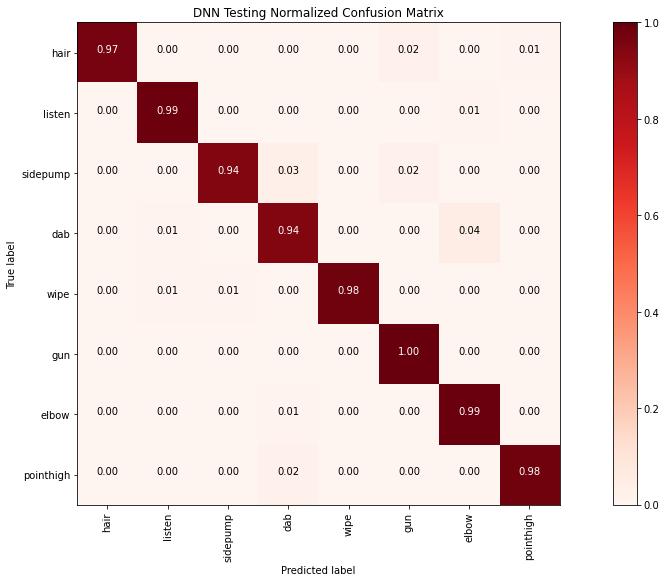

In [30]:
cnf_matrix = confusion_matrix(*dnn_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=activities, title='DNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='DNN Testing Normalized Confusion Matrix')

plt.show()

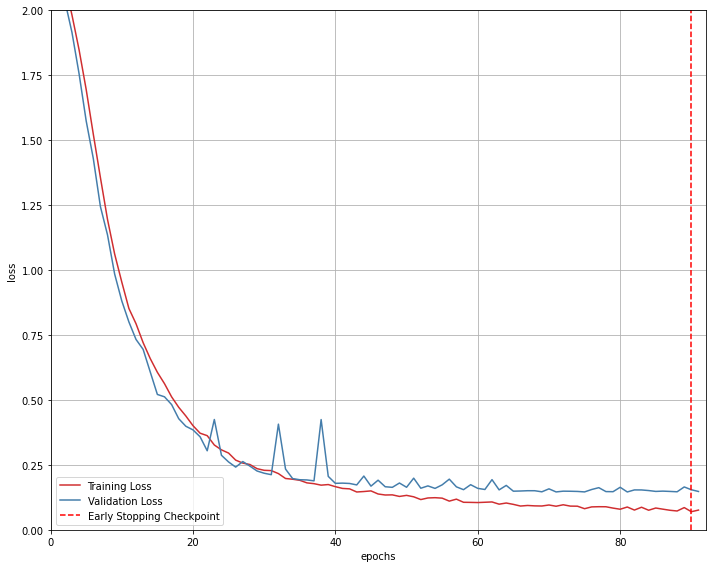

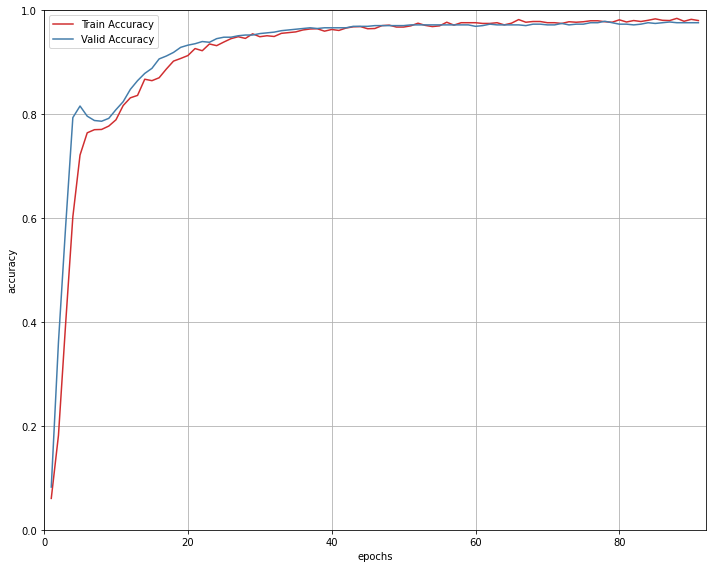

In [31]:
avg_train_losses, avg_valid_losses, train_accuracies, valid_accuracies = trainer.show_evaluation()
plot_avg_loss_per_epoch(avg_train_losses, avg_valid_losses)
plot_accuracy_per_epoch(train_accuracies, valid_accuracies)

In [32]:
performance_df = pd.DataFrame({
    'model': ["SVC", "DNN", "CNN"], 
    'valid_acc': [svc_valid_accuracy, dnn_valid_accuracy, cnn_valid_accuracy], 
    'test_acc': [svc_test_accuracy, dnn_test_accuracy, cnn_test_accuracy], 
})

performance_df

,model,valid_acc,test_acc
0,SVC,0.98396,0.979079
1,DNN,0.97629,0.973501
2,CNN,0.97486,0.974930
